In [111]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
import funcs as func
import matplotlib.pyplot as plt
import sys
import pdb
import glob
import pickle
import matplotlib.cm as cm
import dill
import scipy.stats as sp_st
from statannot import add_stat_annotation
from sklearn.model_selection import LeaveOneGroupOut, KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score


import sys
sys.path.append('/home/jyotika/Utils/hddm/')

import hddm

data_dir = "./Data/processed_data/Y_maze/data_with_animal_ids/"
data_target_dir = "./Data/processed_data/Y_maze/data_with_animal_ids/for_b_cpp_calculation/"
data_target_dir2 = "./Data/processed_data/Y_maze/data_with_animal_ids/for_ddm_models/"
fig_target_dir = "./Figures/Y_maze/"

plt.rcParams["figure.facecolor"] = "w"


In [112]:
block_change_aligned_df = pd.read_csv(data_target_dir2+"block_change_aligned_df.csv")

In [113]:
block_change_aligned_df["nuclei"] = [x.split('-')[0] for x in block_change_aligned_df["condition"]]
block_change_aligned_df["experiment_type"] = [x.split('-')[1] for x in block_change_aligned_df["condition"]]
block_change_aligned_df["experiment_type1"] = [ x if x.split('-')[1] == "Stim" else x.split('-')[1] for x in block_change_aligned_df["condition"]]
block_change_aligned_df["conflict + volatility"] = [x+"-"+y   for x,y in zip(block_change_aligned_df["conflict"], block_change_aligned_df["volatility"])]
block_change_aligned_df["response"] = (block_change_aligned_df["chosen_action"]==block_change_aligned_df["optimal"]).astype(int)

In [114]:
block_change_aligned_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'r_t0', 'r_t1', 'cp',
       'epoch_number', 'reward_p_t0', 'session', 'conflict', 'volatility',
       'condition', 'p_id_solution', 'action_history', 'chosen_action',
       'trial_num', 'animal_id', 'rewarded', 'optimal', 'rt', 'block_num',
       'cpp', 'ideal_B', 'b_t0', 'b_t1', 'MC', 'learning_rate',
       'H(hazard_rate)', 'sigma_estimated', 'rpe_t0', 'rpe_t1', 'u_val',
       'n_val', 'block_change', 'trials_from_change_point',
       'block_change_type', 'block_num_change', 'nuclei', 'experiment_type',
       'experiment_type1', 'conflict + volatility', 'response'],
      dtype='object')

In [115]:
block_change_aligned_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,r_t0,r_t1,cp,epoch_number,reward_p_t0,session,conflict,...,n_val,block_change,trials_from_change_point,block_change_type,block_num_change,nuclei,experiment_type,experiment_type1,conflict + volatility,response
0,0,15.0,15.0,1.015619,0.000000,0.0,1.0,1.0,0.0,High,...,0.317069,0.0,-2.0,left->right,1->2,iSPN,Control,Control,High-High,0
1,1,16.0,16.0,0.000000,0.000000,0.0,1.0,0.0,0.0,High,...,0.406352,0.0,-1.0,left->right,1->2,iSPN,Control,Control,High-High,0
2,2,17.0,17.0,0.987253,0.000000,1.0,2.0,1.0,0.0,High,...,0.441169,1.0,0.0,left->right,1->2,iSPN,Control,Control,High-High,1
3,3,18.0,18.0,0.000000,1.017425,0.0,2.0,0.0,0.0,High,...,1.000000,0.0,1.0,left->right,1->2,iSPN,Control,Control,High-High,1
4,4,19.0,19.0,0.000000,1.002330,0.0,2.0,0.0,0.0,High,...,1.000000,0.0,2.0,left->right,1->2,iSPN,Control,Control,High-High,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178588,178588,198.0,198.0,0.999355,0.000000,0.0,8.0,1.0,5.0,No,...,0.421112,0.0,8.0,right->left,7->8,dSPN,Stim,dSPN-Stim,No-Low,0
178589,178589,199.0,199.0,1.002430,0.000000,0.0,8.0,1.0,5.0,No,...,0.487592,0.0,9.0,right->left,7->8,dSPN,Stim,dSPN-Stim,No-Low,0
178590,178590,226.0,226.0,1.001876,0.000000,0.0,8.0,1.0,5.0,No,...,0.059396,0.0,-2.0,left->right,8->9,dSPN,Stim,dSPN-Stim,No-Low,0
178591,178591,227.0,227.0,1.007628,0.000000,0.0,8.0,1.0,5.0,No,...,1.000000,0.0,-1.0,left->right,8->9,dSPN,Stim,dSPN-Stim,No-Low,1


In [137]:
predicted_responses = pd.DataFrame()
accuracy = pd.DataFrame()
logo = LeaveOneGroupOut()
# for grp in block_change_aligned_df.groupby(["animal_id","conflict","volatility","condition","session"]):
for grp in block_change_aligned_df.groupby(["animal_id","conflict","volatility","condition"]):    
    grp[1]["rpe"] = grp[1]["rpe_t0"].values + grp[1]["rpe_t1"].values
    X = np.array(grp[1][["ideal_B","cpp","rpe"]])
    groups = grp[1]["block_num_change"]
    Y = np.array(grp[1]["response"])
    for train, test in logo.split(X, Y, groups=groups):
        
        
        num_cv = 10 #if len(X[train]) > 5 else len(X[train])-1
#         kf = KFold(n_splits=num_cv, shuffle=True, random_state=42)
        kf = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=42)
        if len(X[train])<5 or len(X[test])<5:
            continue
        clf = LogisticRegressionCV(random_state=0,cv=kf,Cs=[1.0],fit_intercept=False).fit(X[train], Y[train])
        y_predict = clf.predict(X[test])
        score = clf.score(X[test], Y[test])
        # Accuracy score is enough, because this is not a classification problem, but a prediction problem. The classes (block) will not have balanced number of actions
#         try:
#             roc_score = roc_auc_score(Y[test], clf.decision_function(X[test]))
#         except ValueError:
#             roc_score = score
        print(score)
#         print(roc_score)
        print(clf.coef_)
        temp = grp[1].iloc[test].copy()
        temp["predicted_response"] = y_predict
        
        temp["coef(ideal_B)"] = clf.coef_[0][0]
        temp["coef(cpp)"] = clf.coef_[0][1]
        temp["score"] = score
        predicted_responses = predicted_responses.append(temp)

predicted_responses = predicted_responses.reset_index()

#         print("%s %s" % (train, test))

0.5833333333333334
[[0.51867109 0.5446732  0.96882405]]
0.5833333333333334
[[0.52132762 0.53135891 0.95934212]]
0.5666666666666667
[[0.52345574 0.5341077  0.96608387]]
0.6166666666666667
[[0.53641074 0.53014979 0.9488709 ]]
0.5166666666666667
[[0.51571384 0.54429933 0.97833521]]
0.5833333333333334
[[0.52367233 0.56276865 0.97444421]]
0.5666666666666667
[[0.51433559 0.54347904 0.97638097]]
0.43333333333333335
[[0.53363456 0.55883141 0.97869995]]
0.7166666666666667
[[0.51354509 0.5285177  0.94865275]]
0.6
[[0.5196192  0.54090028 0.96001297]]
0.6666666666666666
[[0.5144212  0.53003341 0.95414662]]
0.5
[[0.5254927  0.55010868 0.97619616]]
0.65
[[0.51430949 0.52436732 0.95082625]]
0.4166666666666667
[[0.53814734 0.55282726 0.97075085]]
0.55
[[0.52413087 0.56374924 0.96914767]]
0.6833333333333333
[[0.5057572  0.53585876 0.96105224]]
0.4666666666666667
[[0.53765024 0.54888795 0.97940817]]
0.5333333333333333
[[0.52308301 0.54758341 0.97114271]]
0.5833333333333334
[[0.52618451 0.56782175 0.9816

0.6111111111111112
[[0.92044769 0.25487027 1.71902694]]
0.75
[[0.90784865 0.22064635 1.72788718]]
0.8055555555555556
[[0.91178122 0.22511645 1.68673986]]
0.6944444444444444
[[0.91910858 0.25357433 1.71544541]]
0.6944444444444444
[[0.91026854 0.24082207 1.70741757]]
0.6666666666666666
[[0.91539553 0.24208875 1.70991638]]
0.8194444444444444
[[0.89897516 0.24263785 1.70953096]]
0.6666666666666666
[[0.91084522 0.27274261 1.72285614]]
0.7222222222222222
[[0.91111585 0.25932623 1.70341936]]
0.7222222222222222
[[0.9051315  0.25466089 1.71770742]]
0.7222222222222222
[[0.90685755 0.25834724 1.71828409]]
0.6527777777777778
[[0.90547023 0.26100028 1.72796996]]
0.6388888888888888
[[0.90533329 0.26796885 1.72951693]]
0.7361111111111112
[[0.89667334 0.20409485 1.71620399]]
0.6527777777777778
[[0.91088327 0.27890814 1.73196398]]
0.6805555555555556
[[0.91519438 0.23505398 1.71165633]]
0.6527777777777778
[[0.91980183 0.268606   1.71805297]]
0.7916666666666666
[[0.89770565 0.23936941 1.70332084]]
0.625


0.5694444444444444
[[1.0131726  0.85065017 2.81444613]]
0.7619047619047619
[[0.97295053 0.8702155  2.79719559]]
0.7
[[0.97837235 0.87187848 2.81121415]]
0.85
[[0.94698728 0.85449969 2.81701754]]
0.7254901960784313
[[0.96123197 0.83794794 2.82628411]]
0.5833333333333334
[[0.984203   0.85910512 2.82425962]]
0.7083333333333334
[[0.9656942  0.85523752 2.81622011]]
0.6153846153846154
[[0.97881542 0.87864308 2.82034332]]
0.7222222222222222
[[0.97090933 0.84014846 2.81516419]]
0.6388888888888888
[[0.97621165 0.84543325 2.8240979 ]]
0.7916666666666666
[[0.95944294 0.85135589 2.81225911]]
0.6944444444444444
[[0.97320327 0.84431509 2.79855676]]
0.5555555555555556
[[0.97753246 0.88441251 2.83425742]]
0.8888888888888888
[[0.95778472 0.85081216 2.81019611]]
0.6666666666666666
[[0.97115142 0.8668533  2.81098304]]
0.6666666666666666
[[0.96643623 0.85808731 2.8193853 ]]
0.8333333333333334
[[0.96609748 0.84086048 2.80383982]]
0.5833333333333334
[[0.9715801 0.8713588 2.8183817]]
1.0
[[0.96011639 0.86008

0.75
[[0.89002309 0.75210732 1.05909876]]
0.5555555555555556
[[0.88547004 0.78630966 1.08895879]]
0.5833333333333334
[[0.8959495  0.77358624 1.07420707]]
0.6388888888888888
[[0.89106437 0.77531398 1.07261625]]
0.6666666666666666
[[0.915813   0.76506942 1.02813921]]
0.6666666666666666
[[0.89930029 0.7663569  1.05313922]]
0.6833333333333333
[[0.89370826 0.7551894  1.06935064]]
0.6666666666666666
[[0.87760834 0.78203505 1.08276792]]
0.8
[[0.87985514 0.71772882 1.02579928]]
0.6166666666666667
[[0.89028113 0.78191094 1.07974525]]
0.7666666666666667
[[0.87313542 0.75357182 1.04941038]]
0.7166666666666667
[[0.88461445 0.76419271 1.06044389]]
0.6333333333333333
[[0.90921084 0.59345591 0.88033647]]
0.75
[[0.85673553 0.59384144 0.90891579]]
0.6
[[0.88495922 0.61200864 0.90691927]]
0.55
[[0.91726712 0.64134366 0.91726221]]
0.5833333333333334
[[0.90317384 0.62475048 0.90797548]]
0.6166666666666667
[[0.90043087 0.59210255 0.8967512 ]]
0.8166666666666667
[[0.84887205 0.57929416 0.88151779]]
0.566666

0.8
[[0.95118329 0.74249681 1.81390875]]
0.8
[[0.99310043 0.63263267 1.81705721]]
0.7666666666666667
[[0.99546458 0.69123994 1.84082368]]
0.6666666666666666
[[1.0098192  0.79362881 1.88312962]]
0.6666666666666666
[[0.97207316 0.89056634 2.00492696]]
0.6333333333333333
[[1.02397696 0.77204441 1.86521785]]
0.7916666666666666
[[1.00852329 0.7792211  1.81094527]]
0.6666666666666666
[[1.01016886 0.73526743 1.84495986]]
0.75
[[0.99205685 0.74800817 1.84151172]]
0.7166666666666667
[[1.02445352 0.75928017 1.84224405]]
0.8
[[0.98420777 0.69631899 1.78944012]]
0.7666666666666667
[[0.98322843 0.76429542 1.83254094]]
0.7333333333333333
[[1.01097797 0.71414373 1.8441694 ]]
0.8
[[0.95614065 0.87116364 1.8703953 ]]
0.75
[[0.9868911  0.80373638 1.93770703]]
0.7166666666666667
[[1.01357972 0.70096331 1.86090508]]
0.7333333333333333
[[0.97105698 0.76623679 1.81870321]]
0.7666666666666667
[[1.6336675  0.44913866 2.1471675 ]]
0.8666666666666667
[[1.61178212 0.38862103 2.08402616]]
0.85
[[1.5984254  0.3813

0.6166666666666667
[[0.7796839 0.4948769 0.892913 ]]
0.7
[[0.75800739 0.47317528 0.88075755]]
0.7166666666666667
[[0.9303996  0.716664   0.89331714]]
0.5666666666666667
[[0.93954143 0.75163985 0.91013735]]
0.6833333333333333
[[0.94043131 0.7171299  0.87537431]]
0.7333333333333333
[[0.9170227  0.75064708 0.90342843]]
0.6666666666666666
[[0.9257186  0.73682638 0.90616891]]
0.6666666666666666
[[0.9383881  0.75723725 0.9078104 ]]
0.6333333333333333
[[0.92540299 0.75567511 0.91582791]]
0.6333333333333333
[[0.9321409  0.76852835 0.92656041]]
0.7
[[0.92733171 0.74493379 0.90061669]]
0.48333333333333334
[[0.9360284  0.80305116 0.94604077]]
0.7
[[0.94352066 0.7283309  0.87953011]]
0.5166666666666667
[[0.94264278 0.78779347 0.93941381]]
0.5666666666666667
[[0.94748887 0.73750868 0.91298011]]
0.6666666666666666
[[0.92772636 0.73186893 0.90811872]]
0.55
[[0.96041384 0.76443844 0.92446412]]
0.65
[[0.93821652 0.73228343 0.89520457]]
0.7
[[0.91510522 0.7362442  0.90103144]]
0.6666666666666666
[[0.939

0.7833333333333333
[[1.35266345 0.51443525 1.64199248]]
0.85
[[1.35633832 0.48775624 1.6229441 ]]
0.75
[[1.38006319 0.47982366 1.65693117]]
0.85
[[1.33794051 0.50302188 1.65870607]]
0.7833333333333333
[[1.3756491  0.4906243  1.61598288]]
0.7833333333333333
[[1.3660154  0.46921599 1.64419555]]
0.85
[[1.36173864 0.47282798 1.62663166]]
0.7166666666666667
[[1.37089293 0.50151437 1.68150238]]
0.7666666666666667
[[1.37849    0.47779917 1.63193712]]
0.7833333333333333
[[1.3676092  0.48145189 1.63183938]]
0.6833333333333333
[[1.38247226 0.49525165 1.65569282]]
0.7833333333333333
[[1.35756154 0.50577314 1.64821617]]
0.85
[[1.35672417 0.48652822 1.63517869]]
0.75
[[1.36239118 0.5134328  1.66664461]]
0.8
[[1.35762261 0.50374724 1.6549471 ]]
0.75
[[1.36663067 0.47660196 1.63367091]]
0.7254901960784313
[[1.38464132 0.4835308  1.63956176]]
0.8125
[[1.36924072 0.47240768 1.61958965]]
0.8125
[[1.35763237 0.48382602 1.64574138]]
0.7916666666666666
[[1.36093412 0.50524864 1.64738494]]
0.75
[[1.36874412

0.7916666666666666
[[1.64477286 0.41811741 2.22580541]]
0.7333333333333333
[[1.64256774 0.44868745 2.24780335]]
0.7916666666666666
[[1.60881277 0.4823972  2.24796545]]
0.9583333333333334
[[1.59170592 0.45034059 2.20614252]]
0.8541666666666666
[[1.61245148 0.4150117  2.23203844]]
0.9166666666666666
[[1.6128626  0.42349215 2.20162975]]
0.9166666666666666
[[1.5979277  0.46899683 2.23773192]]
0.8
[[0.7606111  0.35717583 2.57074012]]
0.7833333333333333
[[0.78245036 0.40356559 2.62644465]]
0.6833333333333333
[[0.82982664 0.37214998 2.56889386]]
0.8333333333333334
[[0.75306285 0.37034985 2.57422262]]
0.6166666666666667
[[0.81943184 0.39157849 2.58918625]]
0.7
[[0.82918063 0.32465031 2.55325436]]
0.7833333333333333
[[0.75802766 0.45619101 2.58814845]]
0.6666666666666666
[[0.81908286 0.34380083 2.52408325]]
0.5882352941176471
[[0.84581911 0.40949038 2.57867479]]
0.7333333333333333
[[0.80452035 0.43809513 2.55505387]]
0.625
[[0.81601176 0.44436087 2.5660242 ]]
0.7166666666666667
[[0.79379337 0.4

0.6166666666666667
[[0.31067578 0.06537428 0.83134235]]
0.5333333333333333
[[0.31757598 0.03476733 0.82157306]]
0.6
[[0.31393353 0.06589818 0.82480339]]
0.7666666666666667
[[0.2937019  0.04868069 0.82556903]]
0.6
[[0.30634718 0.05990339 0.83970632]]
0.5666666666666667
[[0.29716555 0.05987389 0.83234547]]
0.55
[[0.29170576 0.06831355 0.85176728]]
0.55
[[0.29459474 0.06430799 0.8594523 ]]
0.7
[[0.29787981 0.05614586 0.82549052]]
0.6
[[0.29929068 0.06204799 0.84503343]]
0.5
[[0.31204021 0.07731448 0.85072972]]
0.65
[[0.30755403 0.06442195 0.82117698]]
0.7166666666666667
[[0.28614446 0.06401606 0.82914843]]
0.7450980392156863
[[0.29325405 0.04794904 0.8189666 ]]
0.6666666666666666
[[0.29549136 0.05598656 0.83006096]]
0.6296296296296297
[[0.30571641 0.06287152 0.8326572 ]]
0.6666666666666666
[[0.30299034 0.06152337 0.82305769]]
0.4166666666666667
[[0.30916689 0.07107486 0.84663734]]
0.625
[[0.29815516 0.06284704 0.83550514]]
0.6666666666666666
[[0.30049695 0.05933574 0.83563988]]
0.5
[[0.30

0.6666666666666666
[[0.7641924  0.27342113 1.86703726]]
0.8333333333333334
[[0.76145513 0.26025204 1.86546898]]
0.6666666666666666
[[0.75776781 0.27610105 1.87470015]]
0.9166666666666666
[[0.75734197 0.27044881 1.86778365]]
0.3333333333333333
[[0.76570038 0.265026   1.87104075]]
1.0
[[0.75283814 0.26820887 1.86676946]]
0.75
[[0.76245784 0.26053264 1.87349315]]
0.8055555555555556
[[0.75387131 0.26081927 1.85309011]]
0.6805555555555556
[[0.7541757  0.30047557 1.8912855 ]]
0.7777777777777778
[[0.76250208 0.24774868 1.8454014 ]]
0.65
[[ 0.27004784 -0.43348516  1.84960711]]
0.75
[[ 0.25216826 -0.37509623  1.87913539]]
0.625
[[ 0.25009783 -0.37863138  1.91223042]]
0.6458333333333334
[[ 0.28221447 -0.44880498  1.84227593]]
0.625
[[ 0.25890952 -0.39031651  1.87457017]]
0.75
[[ 0.25433659 -0.40239623  1.88044375]]
0.6458333333333334
[[ 0.26096965 -0.42747769  1.89494469]]
0.6041666666666666
[[ 0.2973193  -0.46136109  1.84577691]]
0.7916666666666666
[[ 0.26772122 -0.4273019   1.86372616]]
0.6666

0.7361111111111112
[[0.9113254  0.74641517 2.62812421]]
0.6666666666666666
[[0.92941085 0.73688179 2.63479502]]
0.75
[[0.91208931 0.7549178  2.63089274]]
0.6825396825396826
[[0.92340532 0.7458616  2.64264293]]
0.8166666666666667
[[0.90342175 0.74548915 2.62805641]]
0.8166666666666667
[[0.89273276 0.78042619 2.6469558 ]]
0.75
[[0.90417164 0.74771621 2.63560982]]
0.6833333333333333
[[0.91234102 0.74587594 2.64538197]]
0.7666666666666667
[[0.9069863  0.76622529 2.63366542]]
0.5694444444444444
[[0.93253274 0.75501638 2.63906893]]
0.65
[[0.92359343 0.74805639 2.62863077]]
0.7666666666666667
[[0.91000183 0.75157276 2.61956899]]
0.6666666666666666
[[0.91352313 0.7570706  2.64801112]]
0.7166666666666667
[[0.92375551 0.74684869 2.62969992]]
0.7666666666666667
[[0.91548804 0.76269585 2.63277969]]
0.7333333333333333
[[0.91068657 0.74155456 2.64069954]]
0.6666666666666666
[[0.92817216 0.75636218 2.61113998]]
0.75
[[0.92048246 0.72658165 2.61996167]]
0.7333333333333333
[[0.91241939 0.76117947 2.639

0.6979166666666666
[[0.25358848 1.61549044 3.61686358]]
0.6666666666666666
[[-0.14232167  1.15500527  3.83193769]]
0.6875
[[-0.17153071  1.07286267  3.93638847]]
0.8541666666666666
[[-0.10193771  1.07612544  3.81755336]]
0.8125
[[-0.14907026  1.10974086  3.82186494]]
0.7916666666666666
[[-0.12342829  1.05565738  3.82113066]]
0.7708333333333334
[[-0.12649688  1.07349346  3.86638047]]
0.8333333333333334
[[-0.12713528  1.06180926  3.8334575 ]]
0.7916666666666666
[[-0.12617133  1.05911085  3.92098476]]
0.8541666666666666
[[-0.13253942  1.09501784  3.79945993]]
0.7916666666666666
[[-0.1247401   1.01325364  3.77611983]]
0.7916666666666666
[[-0.15398489  1.04575899  3.86485042]]
0.8333333333333334
[[-0.1328892   0.99948996  3.89916307]]
0.8205128205128205
[[-0.14622547  1.08199346  3.8768716 ]]
0.8888888888888888
[[-0.11548404  1.04388958  3.79162825]]
0.75
[[-0.16878369  1.0854838   3.8372655 ]]
0.7777777777777778
[[-0.13561557  0.97279941  3.91095685]]
0.7777777777777778
[[-0.14121495  1.02

0.5833333333333334
[[1.31892438 0.74284243 1.71968228]]
0.6833333333333333
[[1.32158959 0.73124896 1.74719544]]
0.8166666666666667
[[1.29261592 0.65763155 1.68646296]]
0.8833333333333333
[[1.25676415 0.71450029 1.70787275]]
0.7666666666666667
[[1.31111353 0.74140882 1.75551168]]
0.7166666666666667
[[1.33025557 0.70331609 1.69619017]]
0.8333333333333334
[[1.28541858 0.73322522 1.70615193]]
0.5833333333333334
[[0.67163502 0.4864293  1.39813148]]
0.8333333333333334
[[0.64296006 0.37426607 1.34562012]]
0.5833333333333334
[[0.70754143 0.34858365 1.38949033]]
0.5
[[0.70751251 0.55840288 1.40237955]]
0.75
[[0.61345899 0.45265376 1.53095109]]
0.75
[[0.62718897 0.42763618 1.43022022]]
0.9166666666666666
[[0.63153969 0.38788284 1.3632309 ]]
0.75
[[0.6075443  0.5449272  1.52068544]]
0.9166666666666666
[[0.58679208 0.51680367 1.39259825]]
0.75
[[0.61393164 0.43302069 1.4410392 ]]
0.5
[[0.71450057 0.53922561 1.41905146]]
0.75
[[0.68424671 0.44902422 1.38330603]]
0.5833333333333334
[[0.7201859  0.54

0.6166666666666667
[[0.49665206 0.26277828 0.9010931 ]]
0.6666666666666666
[[0.50397966 0.24566762 0.88592169]]
0.5833333333333334
[[0.51167102 0.25478613 0.89037526]]
0.6333333333333333
[[0.4957557  0.23510384 0.89064953]]
0.5
[[0.49955692 0.26620348 0.91794353]]
0.5833333333333334
[[0.50741855 0.25573172 0.89880322]]
0.6833333333333333
[[0.4954886  0.24436964 0.89102168]]
0.6333333333333333
[[0.49852911 0.25175808 0.89178951]]
0.6333333333333333
[[0.50874444 0.24293298 0.88974348]]
0.5666666666666667
[[0.51125986 0.26061386 0.89621252]]
0.7333333333333333
[[0.49948512 0.23817042 0.88660122]]
0.6666666666666666
[[0.50154802 0.24440553 0.88019008]]
0.6833333333333333
[[0.50256714 0.25757427 0.90037374]]
0.6
[[0.50274096 0.25560561 0.89660706]]
0.55
[[0.50828775 0.23591221 0.88957617]]
0.6666666666666666
[[0.50266678 0.23878182 0.88964129]]
0.4666666666666667
[[0.51044897 0.26352666 0.90221709]]
0.6833333333333333
[[0.49540771 0.24218073 0.89387564]]
0.6
[[0.51530186 0.26016327 0.884644

0.4444444444444444
[[0.26068109 0.02287213 0.83869361]]
0.6
[[0.26267156 0.01880969 0.81449393]]
0.75
[[ 0.25720298 -0.00856427  0.79718865]]
0.6333333333333333
[[ 0.29046766 -0.01178455  0.77868558]]
0.6
[[ 0.2507685  -0.02612097  0.7752342 ]]
0.5833333333333334
[[ 0.26032407 -0.00110658  0.80112669]]
0.5666666666666667
[[0.25131145 0.03125453 0.81932128]]
0.6166666666666667
[[0.25282675 0.00121927 0.80423415]]
0.5
[[0.28702766 0.0710636  0.86133579]]
0.7
[[ 0.20483709 -0.06037347  0.76434783]]
0.6666666666666666
[[ 0.62637597 -0.480955    1.82273518]]
0.6166666666666667
[[ 0.61757004 -0.52029086  1.85455436]]
0.7333333333333333
[[ 0.60937601 -0.50195409  1.83198525]]
0.7166666666666667
[[ 0.60559124 -0.48575681  1.85210886]]
0.7333333333333333
[[ 0.61137342 -0.49599038  1.83253246]]
0.65
[[ 0.62182004 -0.47645354  1.82786785]]
0.7
[[ 0.60572865 -0.46341509  1.84339133]]
0.7333333333333333
[[ 0.60378012 -0.48759792  1.84808579]]
0.6333333333333333
[[ 0.62527733 -0.48556412  1.83988905

0.7142857142857143
[[0.5238164  0.09475397 2.06888868]]
0.6666666666666666
[[0.523721   0.16334775 2.07505007]]
0.7638888888888888
[[0.51163937 0.129091   2.07155513]]
0.6388888888888888
[[0.52548053 0.11496574 2.08197564]]
0.6111111111111112
[[0.54007165 0.10680625 2.0729364 ]]
0.7222222222222222
[[0.52691864 0.13229999 2.05719741]]
0.6666666666666666
[[0.5090549  0.16768429 2.0994108 ]]
0.7291666666666666
[[0.52285321 0.13609314 2.06179963]]
0.7083333333333334
[[0.51681419 0.13536278 2.08061165]]
0.5833333333333334
[[0.52719366 0.13536799 2.08280944]]
0.7666666666666667
[[0.51965546 0.1518172  2.07460454]]
0.7142857142857143
[[0.52957808 0.1455915  2.04171595]]
0.6666666666666666
[[0.52653416 0.12370083 2.06751281]]
0.8333333333333334
[[0.52009899 0.12669419 2.07215497]]
0.7333333333333333
[[0.52276161 0.13949817 2.06906965]]
0.5952380952380952
[[0.54483301 0.10274443 2.06980725]]
0.6309523809523809
[[0.53587232 0.11132986 2.03892668]]
0.6309523809523809
[[0.53229377 0.12151861 2.072

0.75
[[-0.29705709 -0.05569816  4.32404497]]
0.8333333333333334
[[-0.26605898 -0.18018508  4.43891269]]
0.9166666666666666
[[-0.21779265 -0.15433976  4.26829451]]
0.8333333333333334
[[-0.24751166 -0.1038451   4.30451795]]
0.75
[[-0.28478412 -0.12150346  4.3492106 ]]
0.875
[[-0.23725776 -0.16013621  4.32165632]]
0.9333333333333333
[[-0.26919129 -0.07464749  4.29966617]]
0.8333333333333334
[[-0.27394907 -0.09136582  4.31667371]]
0.9166666666666666
[[-0.26515067 -0.06708393  4.2743884 ]]
0.8333333333333334
[[-0.29924562 -0.03738724  4.30589881]]
0.875
[[-0.25255878 -0.0817844   4.3559198 ]]
0.8333333333333334
[[-0.2703651  -0.13676258  4.42314753]]
1.0
[[-0.23898578 -0.07106032  4.25560859]]
0.9166666666666666
[[-0.22083885 -0.1769317   4.26868609]]
0.6666666666666666
[[0.27070265 0.80213145 3.44281827]]
0.6547619047619048
[[0.26973936 0.82103066 3.43971159]]
0.6785714285714286
[[0.27471668 0.83190318 3.47465997]]
0.5357142857142857
[[0.29968875 0.80258435 3.41656884]]
0.6071428571428571


0.7083333333333334
[[ 1.14213366 -0.07695629  1.53836075]]
0.8125
[[ 1.11488988 -0.11620209  1.52065217]]
0.7083333333333334
[[ 1.14231439 -0.10942902  1.55155429]]
0.7666666666666667
[[ 1.09561897 -0.15961726  1.56912706]]
0.7291666666666666
[[ 1.15330329 -0.0776257   1.52629532]]
0.7708333333333334
[[ 1.09612258 -0.02549733  1.60179596]]
0.7916666666666666
[[ 1.14081883 -0.1046984   1.52886104]]
0.8125
[[ 1.10658863 -0.08701215  1.55866723]]
0.6666666666666666
[[ 1.11523016 -0.02720204  1.61403466]]
0.7692307692307693
[[ 1.12429261 -0.10179031  1.55421699]]
0.5925925925925926
[[ 1.14842384 -0.07902794  1.58751961]]
0.8
[[ 1.11654869 -0.07808334  1.57255412]]
0.5
[[ 1.13116292 -0.06280284  1.56281587]]
0.5833333333333334
[[ 1.14302352 -0.12052433  1.55455457]]
0.7833333333333333
[[ 1.13370699 -0.0825098   1.54479096]]
0.8166666666666667
[[ 1.07694417 -0.07705313  1.59913086]]
0.7333333333333333
[[ 1.13400462 -0.17590715  1.55165792]]
0.7333333333333333
[[ 1.10509369 -0.04485244  1.592

0.6458333333333334
[[0.53174638 0.49924119 1.01909577]]
0.7083333333333334
[[0.53620562 0.48752678 1.0104366 ]]
0.6875
[[0.51738685 0.48875613 1.0285999 ]]
0.5416666666666666
[[0.52875585 0.52017549 1.04992426]]
0.75
[[0.52207171 0.48746483 1.00752909]]
0.6875
[[0.54408491 0.46607758 0.99668365]]
0.5
[[0.5467143  0.49813552 1.0182621 ]]
0.6875
[[0.5214823  0.48233459 1.01543184]]
0.5416666666666666
[[0.5456519  0.50804761 1.0169563 ]]
0.75
[[0.50973948 0.47061399 1.01458866]]
0.6
[[0.52724644 0.5097407  1.03329008]]
1.0
[[0.53051697 0.48898314 1.00982022]]
0.7333333333333333
[[0.5362023  0.46793551 0.98869823]]
0.55
[[0.52489602 0.4867944  1.01702696]]
0.5333333333333333
[[0.54742252 0.49380302 1.01888453]]
0.6
[[0.53716877 0.50008829 1.02742137]]
0.5
[[0.55762318 0.48614062 1.01011204]]
0.5555555555555556
[[ 0.15060065 -0.07750909  0.90638363]]
0.5555555555555556
[[ 0.15398121 -0.03728124  0.95467252]]
0.5555555555555556
[[ 0.18615298 -0.06028363  0.91655697]]
0.5833333333333334
[[ 0.

0.5833333333333334
[[ 1.24150784 -0.13002215  1.54484104]]
0.75
[[ 1.23545956 -0.11973518  1.54641479]]
0.6833333333333333
[[ 1.23799759 -0.09543784  1.58160569]]
0.85
[[ 1.20109861 -0.0755386   1.56106223]]
0.8
[[ 1.23692875 -0.10365648  1.51926125]]
0.6666666666666666
[[ 1.21954783 -0.04876659  1.60514836]]
0.7666666666666667
[[ 0.19228125 -0.4642016   1.76453255]]
0.75
[[ 0.20783618 -0.41954984  1.75556252]]
0.75
[[ 0.21462788 -0.51058354  1.75437157]]
0.6666666666666666
[[ 0.19264363 -0.41106101  1.80785754]]
0.6458333333333334
[[ 0.22329284 -0.47726189  1.73791294]]
0.625
[[ 0.21863317 -0.43082008  1.7589365 ]]
0.6875
[[ 0.22955742 -0.45408106  1.76432134]]
0.6458333333333334
[[ 0.21831209 -0.44447627  1.76068877]]
0.7708333333333334
[[ 0.15782089 -0.44288443  1.78470006]]
0.6875
[[ 0.18283977 -0.39396965  1.78603342]]
0.625
[[ 0.19958433 -0.44654943  1.81069654]]
0.75
[[ 0.21201411 -0.43659184  1.72064518]]
0.5833333333333334
[[ 0.24467763 -0.46004785  1.75971108]]
0.708333333333

0.9166666666666666
[[-0.68809352  0.97997377  5.15951031]]
0.8958333333333334
[[-0.69403026  0.97485021  5.22722412]]
0.8125
[[-0.70464676  0.9912021   5.18670014]]
0.9166666666666666
[[-0.66346175  0.95176568  5.14154202]]
0.7916666666666666
[[-0.70694975  1.04139112  5.23519452]]
0.8125
[[-0.69880824  0.99358858  5.17924834]]
0.6875
[[-0.70287379  0.99673285  5.27107624]]
0.8125
[[-0.70313524  0.98757771  5.27141866]]
0.9375
[[-0.66364628  0.97571324  5.14439815]]
0.7083333333333334
[[-0.73176389  0.99340011  5.31241061]]
0.8717948717948718
[[-0.68341096  0.96690018  5.17187762]]
0.7222222222222222
[[-0.7010296   1.01717442  5.21768329]]
0.75
[[-0.72404837  1.00108439  5.3203439 ]]
0.9166666666666666
[[-0.66981431  0.97404233  5.16241295]]
0.8333333333333334
[[-0.68751392  0.97140064  5.15199568]]
0.8888888888888888
[[-0.67113279  0.9565462   5.14723946]]
0.8518518518518519
[[-0.69730132  1.01424978  5.17282456]]
0.9333333333333333
[[-0.68720337  1.01071132  5.20611991]]
0.8541666666

0.6666666666666666
[[0.76882379 0.59720672 0.95274053]]
0.6078431372549019
[[0.76161003 0.60565538 0.97438153]]
0.6875
[[0.76244801 0.61268451 0.96289707]]
0.7083333333333334
[[0.7608776  0.60482268 0.96165167]]
0.6041666666666666
[[0.76570601 0.60371978 0.96372704]]
0.6333333333333333
[[0.77139674 0.61543378 0.95865274]]
0.6410256410256411
[[0.76740751 0.60095785 0.97142641]]
0.6111111111111112
[[0.76615573 0.60860238 0.96422339]]
0.6111111111111112
[[0.76316152 0.60994075 0.96931627]]
0.6666666666666666
[[0.76526612 0.60581515 0.96705697]]
0.6666666666666666
[[0.76150817 0.61336108 0.96907811]]
0.75
[[0.7620145  0.60255856 0.96545154]]
0.5
[[0.76563115 0.61720558 0.97581735]]
0.7916666666666666
[[0.75966473 0.60350373 0.96500014]]
0.5
[[0.76810389 0.61007382 0.96727644]]
0.8333333333333334
[[0.7591531  0.60022917 0.96002882]]
0.5333333333333333
[[0.77334818 0.61880061 0.96931718]]
0.5
[[0.76784602 0.61022424 0.96647987]]
0.7916666666666666
[[0.75633769 0.60906629 0.96777042]]
0.70833

0.8205128205128205
[[1.39028711 0.68680557 1.8461819 ]]
0.8611111111111112
[[1.39099529 0.67082796 1.8491132 ]]
0.9166666666666666
[[1.38492544 0.6941582  1.85206094]]
0.7777777777777778
[[1.40071172 0.69093144 1.84727934]]
0.7916666666666666
[[1.40081706 0.68910192 1.85648947]]
0.6666666666666666
[[1.40740828 0.68655277 1.85352524]]
0.7916666666666666
[[1.3959847  0.69300701 1.86060638]]
0.8166666666666667
[[1.39671532 0.68707943 1.85123306]]
0.75
[[1.40144582 0.68715187 1.85108124]]
0.6666666666666666
[[1.40301734 0.678935   1.84917131]]
0.75
[[1.4024287  0.67580536 1.84869657]]
0.8666666666666667
[[1.38966242 0.6813973  1.85784812]]
0.9166666666666666
[[1.3967303  0.67804318 1.85155937]]
0.7166666666666667
[[1.39644524 0.68626855 1.86844269]]
0.65
[[1.55632763 1.15260807 1.87306754]]
0.7166666666666667
[[1.54177751 1.14798556 1.84858489]]
0.8
[[1.54149291 1.07867518 1.8122451 ]]
0.8
[[1.534576   1.13467116 1.82878888]]
0.7833333333333333
[[1.53703599 1.14935225 1.83398012]]
0.833333

0.7
[[1.51726794 0.97810207 2.60493679]]
0.85
[[1.48965042 1.02325045 2.62459013]]
0.7333333333333333
[[1.5182796  0.9928296  2.63080905]]
0.7666666666666667
[[1.51334721 1.00354951 2.64707715]]
0.8823529411764706
[[1.47935696 0.93154635 2.60216863]]
0.7083333333333334
[[1.53017827 0.98196842 2.59483052]]
0.7916666666666666
[[1.50742998 0.9382143  2.61265017]]
0.6458333333333334
[[1.53942404 0.99628869 2.61315024]]
0.8541666666666666
[[1.4932317  0.96880559 2.59304363]]
0.6923076923076923
[[1.51743658 0.98729327 2.6226385 ]]
0.9166666666666666
[[1.49896173 0.96150832 2.5871272 ]]
0.85
[[1.50165373 0.95549903 2.60749107]]
0.6666666666666666
[[1.53452948 0.99220168 2.64837558]]
0.75
[[1.49369964 1.01009925 2.62564823]]
0.6666666666666666
[[1.53827665 0.91217475 2.63473892]]
0.8611111111111112
[[1.48736407 0.95847035 2.61919654]]
0.7777777777777778
[[1.51514055 1.01424139 2.64559596]]
0.9444444444444444
[[1.47984205 1.0075428  2.6216577 ]]
0.8888888888888888
[[1.49163159 1.00177579 2.6399

In [138]:
grp[1].columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'r_t0', 'r_t1', 'cp',
       'epoch_number', 'reward_p_t0', 'session', 'conflict', 'volatility',
       'condition', 'p_id_solution', 'action_history', 'chosen_action',
       'trial_num', 'animal_id', 'rewarded', 'optimal', 'rt', 'block_num',
       'cpp', 'ideal_B', 'b_t0', 'b_t1', 'MC', 'learning_rate',
       'H(hazard_rate)', 'sigma_estimated', 'rpe_t0', 'rpe_t1', 'u_val',
       'n_val', 'block_change', 'trials_from_change_point',
       'block_change_type', 'block_num_change', 'nuclei', 'experiment_type',
       'experiment_type1', 'conflict + volatility', 'response', 'rpe'],
      dtype='object')

In [140]:
grp[1][["b_t0","b_t1","block_num_change","rpe","ideal_B","cpp","response","optimal","chosen_action","rewarded"]]

,b_t0,b_t1,block_num_change,rpe,ideal_B,cpp,response,optimal,chosen_action,rewarded
178506,0.016476,0.922387,1->2,-0.016476,0.905911,0.120670,0,right,left,0.0
178507,0.005939,0.864227,1->2,-0.005939,0.858288,0.058174,0,right,left,0.0
178508,0.003314,0.839572,1->2,0.987818,-0.836258,0.019608,1,left,left,1.0
178509,0.322688,0.831745,1->2,-0.831745,0.509057,1.000000,0,left,right,0.0
178510,0.440411,0.000000,1->2,0.000000,0.440411,0.038462,0,left,right,0.0
...,...,...,...,...,...,...,...,...,...,...
178588,0.700800,0.008707,7->8,-0.008707,0.692093,0.045340,0,left,right,0.0
178589,0.688994,0.000434,7->8,-0.000434,0.688559,0.039402,0,left,right,0.0
178590,0.963649,0.021380,8->9,-0.021380,0.942269,0.251903,0,left,right,0.0
178591,0.831844,0.008514,8->9,0.175783,0.823331,0.019608,1,left,left,1.0


In [141]:
predicted_responses[["b_t0","b_t1","block_num_change","rpe","ideal_B","cpp","predicted_response","response","optimal","chosen_action","rewarded"]][:50]


,b_t0,b_t1,block_num_change,rpe,ideal_B,cpp,predicted_response,response,optimal,chosen_action,rewarded
0,7.445216e-01,6.963622e-03,1->2,-6.963622e-03,0.737558,0.084190,1,0,left,right,0.0
1,7.206437e-01,2.978673e-03,1->2,-2.978673e-03,-0.717665,0.066930,0,0,left,right,0.0
2,7.032593e-01,1.758602e-03,1->2,-1.758602e-03,0.701501,0.061975,1,1,right,right,0.0
3,6.882392e-01,1.168429e-03,1->2,1.016257e+00,-0.687071,0.028322,1,1,right,right,1.0
4,6.818005e-01,2.785712e-01,1->2,7.237584e-01,-0.403229,0.028322,1,1,right,right,1.0
5,6.755441e-01,9.979450e-01,1->2,-9.979450e-01,-0.322401,1.000000,0,1,right,right,0.0
6,4.609028e-01,0.000000e+00,1->2,-4.609028e-01,-0.460903,1.000000,0,0,right,left,0.0
7,0.000000e+00,4.609028e-01,1->2,5.496009e-01,0.460903,0.028322,1,1,right,right,1.0
8,1.305389e-02,7.434862e-01,1->2,2.529125e-01,0.730432,0.028322,1,1,right,right,1.0
9,2.573807e-02,9.853767e-01,1->2,9.191156e-03,0.959639,0.037771,1,1,right,right,1.0


In [142]:
predicted_responses.to_csv(data_target_dir2+"predicted_responses_from_b_cpp.csv")

In [143]:
predicted_responses = pd.read_csv(data_target_dir2+"predicted_responses_from_b_cpp.csv")

In [144]:
predicted_responses.iloc[:50][["ideal_B","cpp","trials_from_change_point","response","predicted_response"]]

,ideal_B,cpp,trials_from_change_point,response,predicted_response
0,0.737558,0.084190,-2.0,0,1
1,-0.717665,0.066930,-1.0,0,0
2,0.701501,0.061975,0.0,1,1
3,-0.687071,0.028322,1.0,1,1
4,-0.403229,0.028322,2.0,1,1
5,-0.322401,1.000000,3.0,1,0
6,-0.460903,1.000000,4.0,0,0
7,0.460903,0.028322,5.0,1,1
8,0.730432,0.028322,6.0,1,1
9,0.959639,0.037771,7.0,1,1


In [145]:
# sns.plot(x="coef(ideal_B)",y="coef(cpp)",col="conflict + volatility",hue="condition",data=predicted_responses,kind='scatter',col_wrap=2,facet_kws={'sharey':False})

In [146]:
temp = predicted_responses.groupby(["conflict","condition","volatility"])["score"].mean()
mean_accuracy = pd.DataFrame()
mean_accuracy["conflict"] = [ x[0] for x in temp.index]
mean_accuracy["condition"] = [ x[1] for x in temp.index]
mean_accuracy["volatility"] = [ x[2] for x in temp.index]
mean_accuracy["Accuracy"] = temp.values
mean_accuracy = mean_accuracy.reset_index()

In [147]:
mean_accuracy

,index,conflict,condition,volatility,Accuracy
0,0,High,dSPN-Control,High,0.647078
1,1,High,dSPN-Control,Low,0.645452
2,2,High,dSPN-Stim,High,0.638996
3,3,High,dSPN-Stim,Low,0.637479
4,4,High,iSPN-Control,High,0.608665
5,5,High,iSPN-Control,Low,0.595432
6,6,High,iSPN-Stim,High,0.594608
7,7,High,iSPN-Stim,Low,0.590608
8,8,Low,dSPN-Control,High,0.773040
9,9,Low,dSPN-Control,Low,0.767002


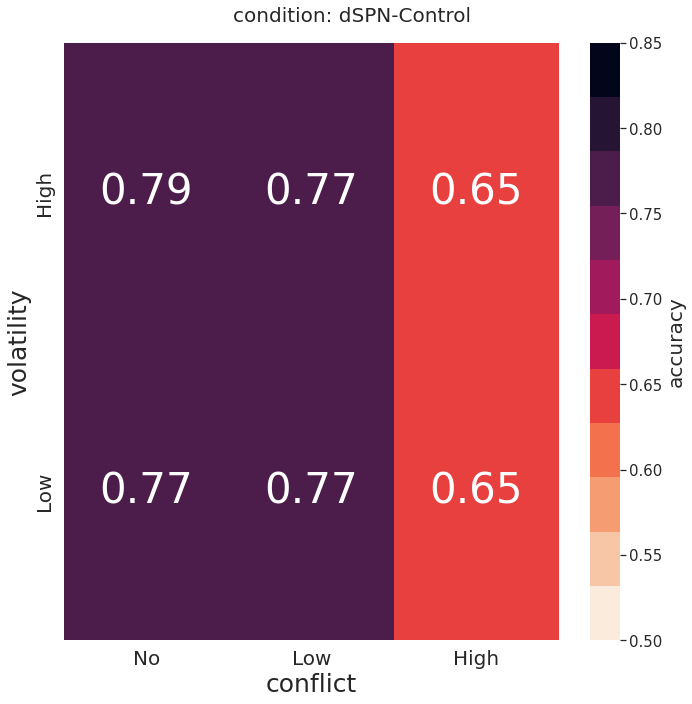

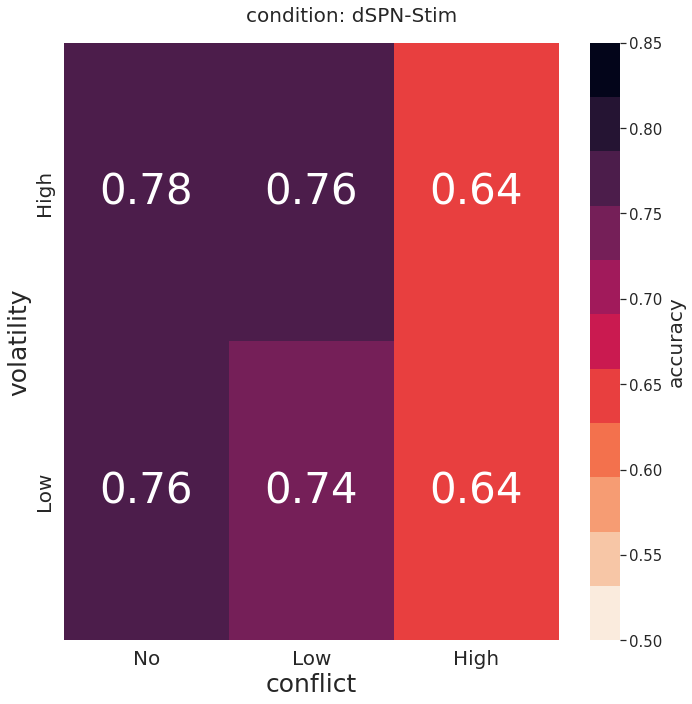

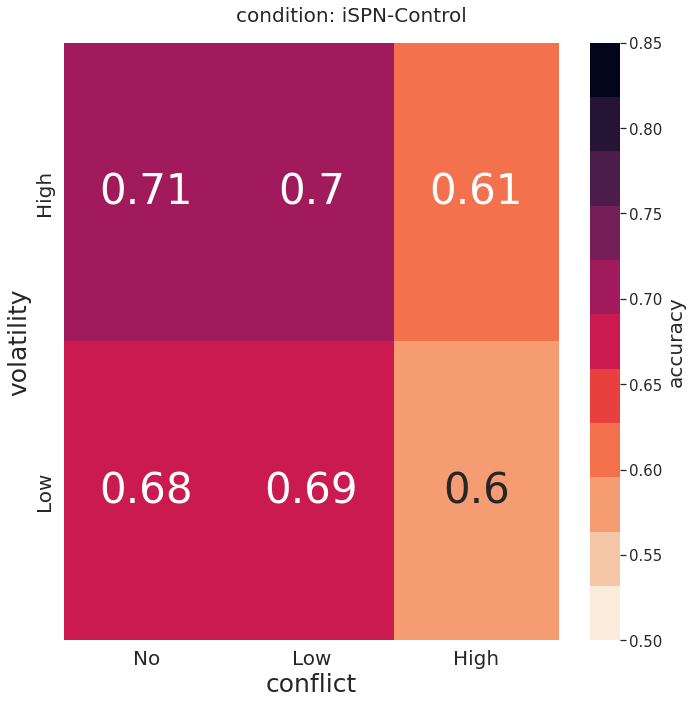

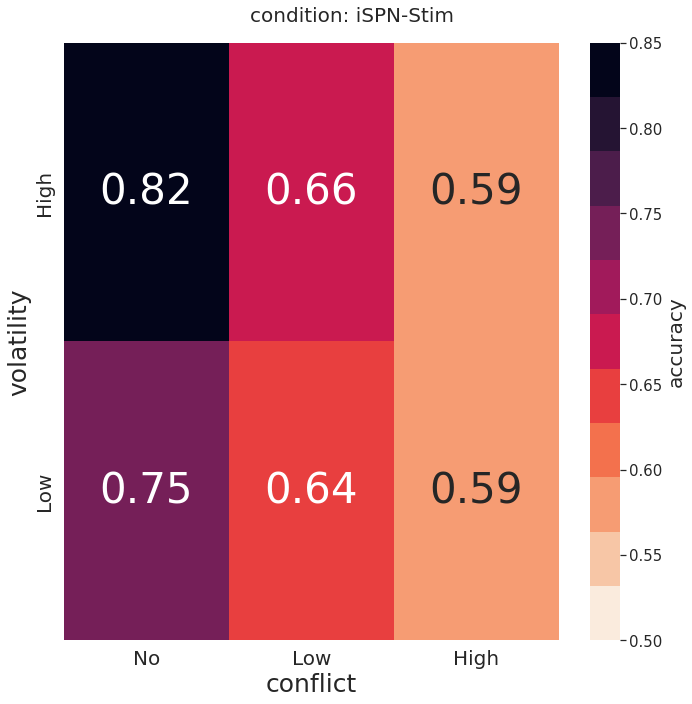

In [148]:
cmap = cm.get_cmap('rocket_r',11)

for grp in mean_accuracy.groupby("condition"):
    temp = grp[1][["conflict","volatility","Accuracy"]].copy()
    temp_pivot = temp.pivot(index="volatility",columns="conflict")
    temp_pivot.columns = temp_pivot.columns.get_level_values(1)
    temp_pivot1 = temp_pivot[["No","Low","High"]]
    temp_pivot1 = temp_pivot1.reindex(['High','Low'], axis=0)
    fig,ax = pl.subplots(1,1,figsize=(10,10))
    g1 = sns.heatmap(data=temp_pivot1,ax=ax,vmin=0.5,vmax=0.85,cmap=cmap,cbar_kws={'label': 'accuracy'},annot=True)
    fig.suptitle("condition: "+grp[0],fontsize=20)
    for x in ax.get_xticklabels():
        x.set_fontsize(20)
    for x in ax.get_yticklabels():
        x.set_fontsize(20)        
    ax.set_ylabel(ax.get_ylabel(),fontsize=25)
    ax.set_xlabel(ax.get_xlabel(),fontsize=25)
    fig.subplots_adjust(left=0.1,right=0.96,top=0.93,bottom=0.1)
    cbar_axes = g1.figure.axes[-1]
    for y in cbar_axes.get_yticklabels():
        y.set_fontsize(15)
#         y.set_fontweight('bold')
    cbar_axes.set_ylabel(cbar_axes.get_ylabel(),fontsize=20)#,fontweight='bold')
    fig.savefig(fig_target_dir+"prediction_behavior_from_b_cpp_"+grp[0]+".png")

In [149]:
cbar_axes.get_yticklabels()
# grp[1].pivot(index="conflict",columns="volatility")

[Text(1, 0.5, '0.50'),
 Text(1, 0.55, '0.55'),
 Text(1, 0.6000000000000001, '0.60'),
 Text(1, 0.65, '0.65'),
 Text(1, 0.7, '0.70'),
 Text(1, 0.75, '0.75'),
 Text(1, 0.8, '0.80'),
 Text(1, 0.8500000000000001, '0.85')]

/tmp/ipykernel_30019/1736520203.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = pl.subplots(1,1,figsize=(10,10))


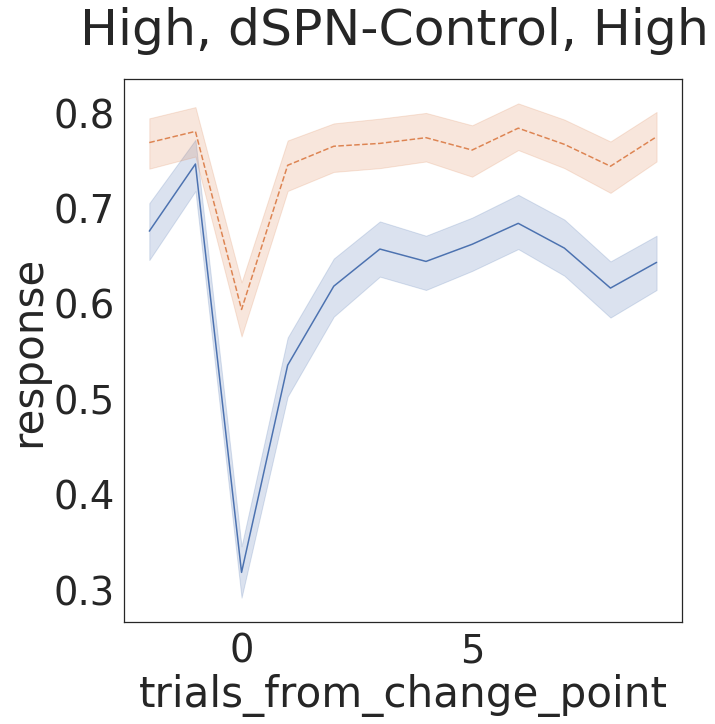

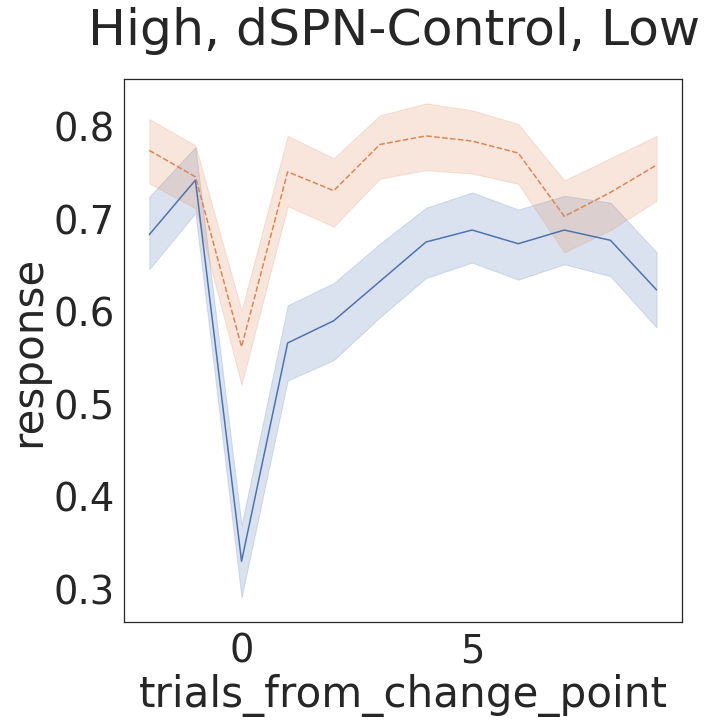

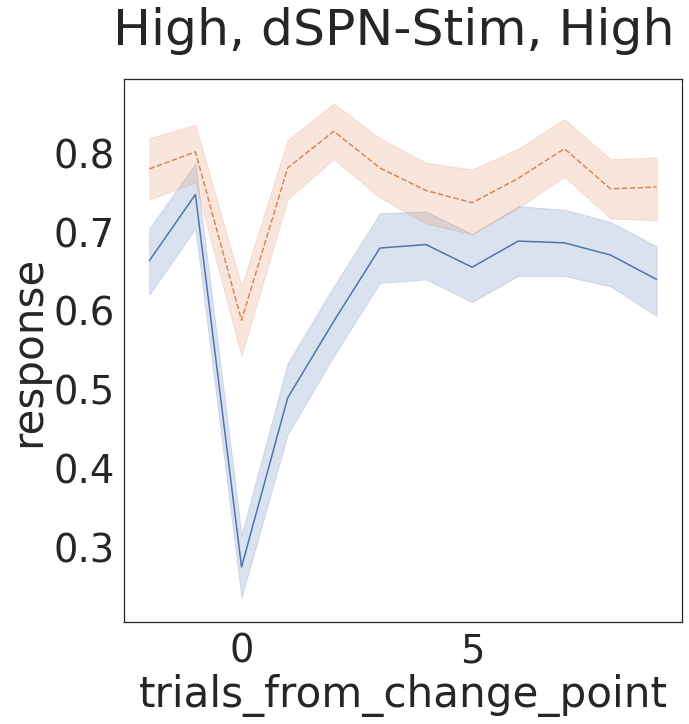

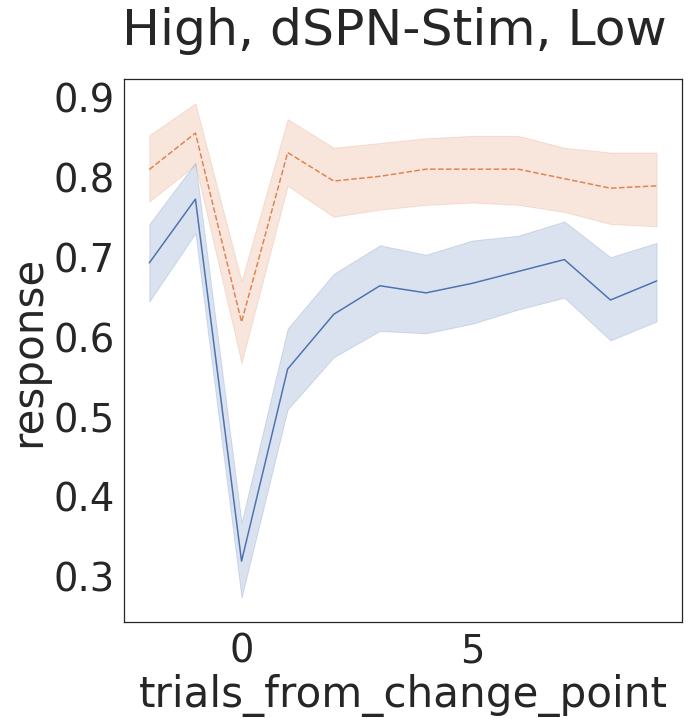

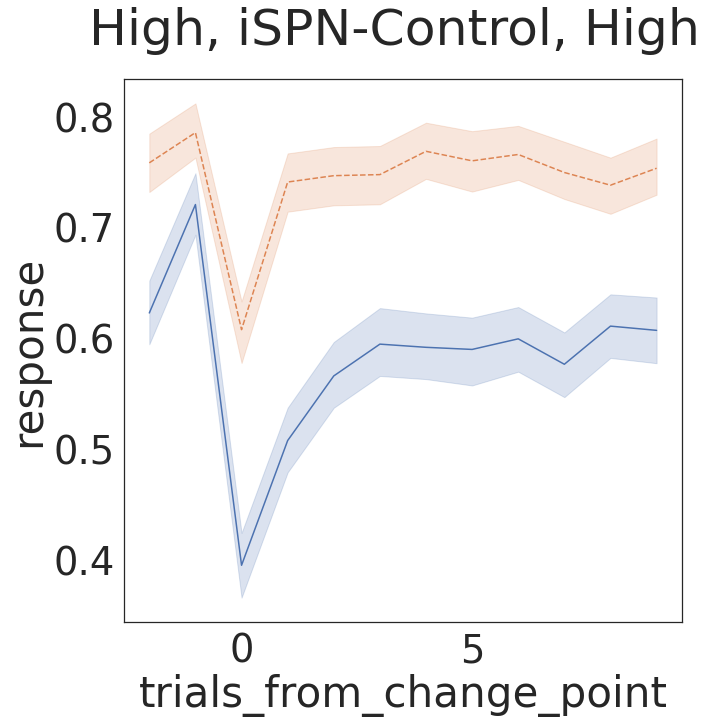

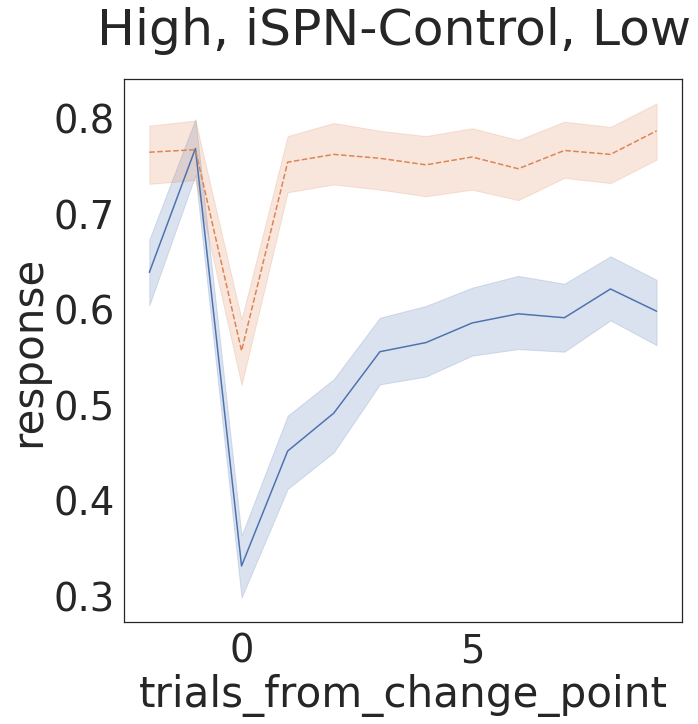

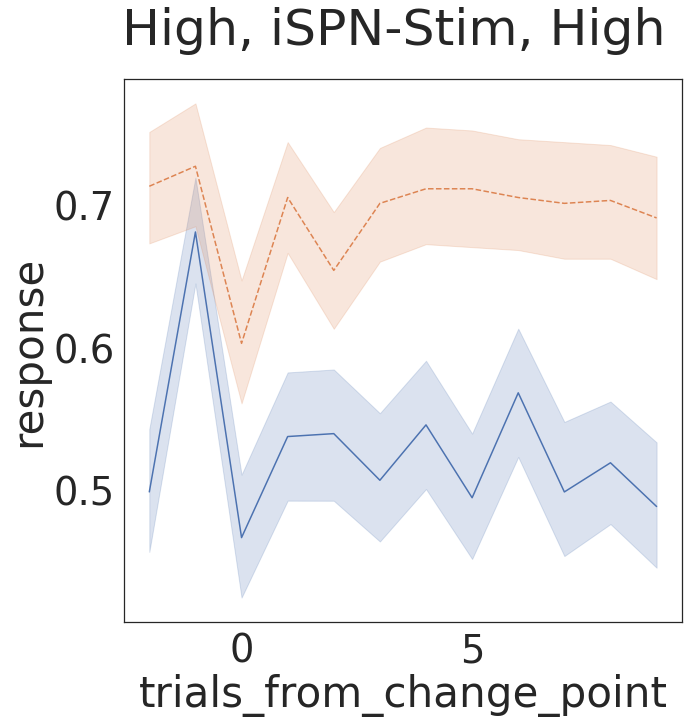

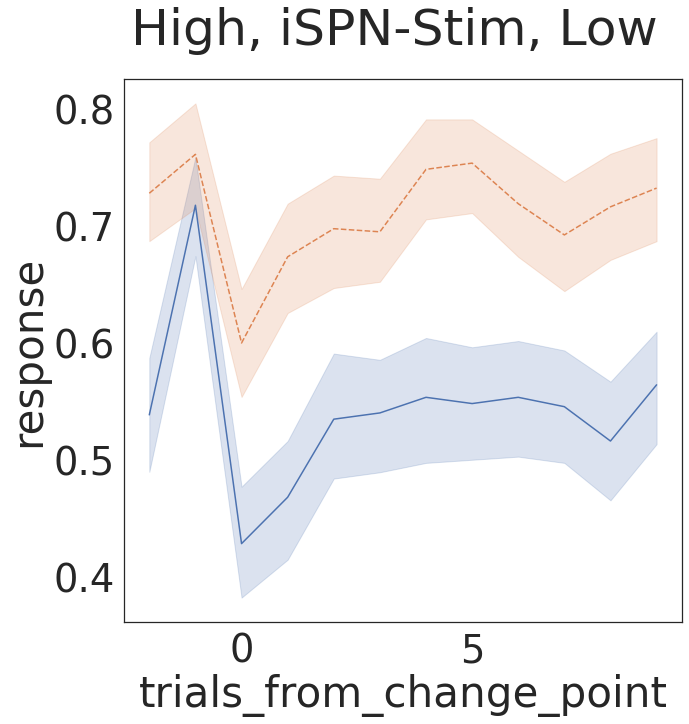

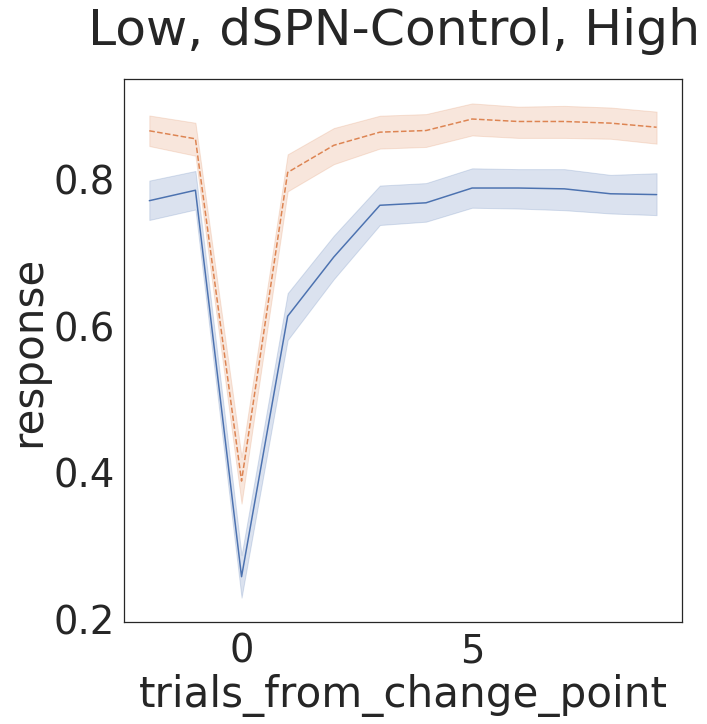

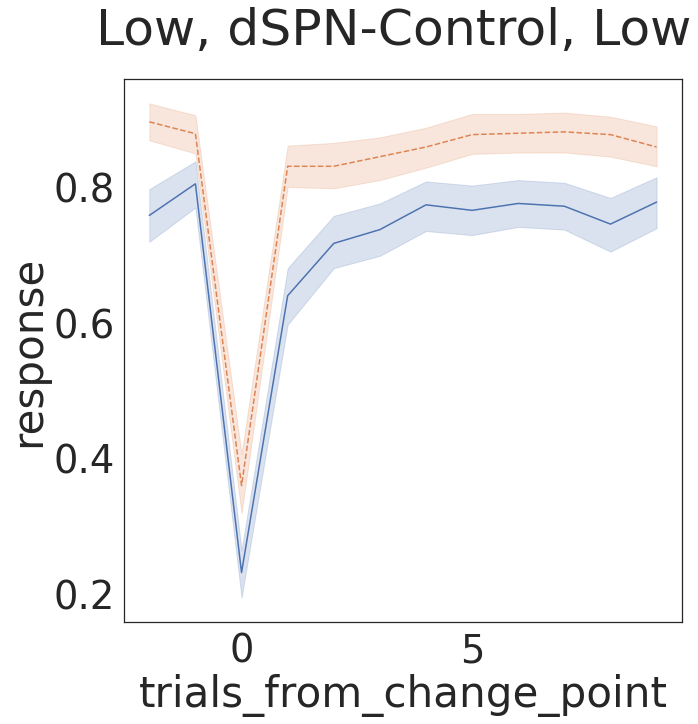

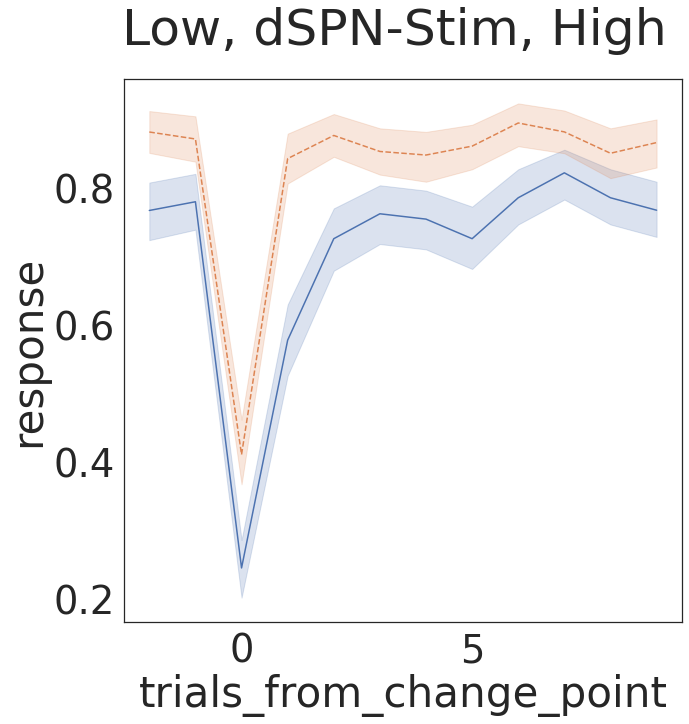

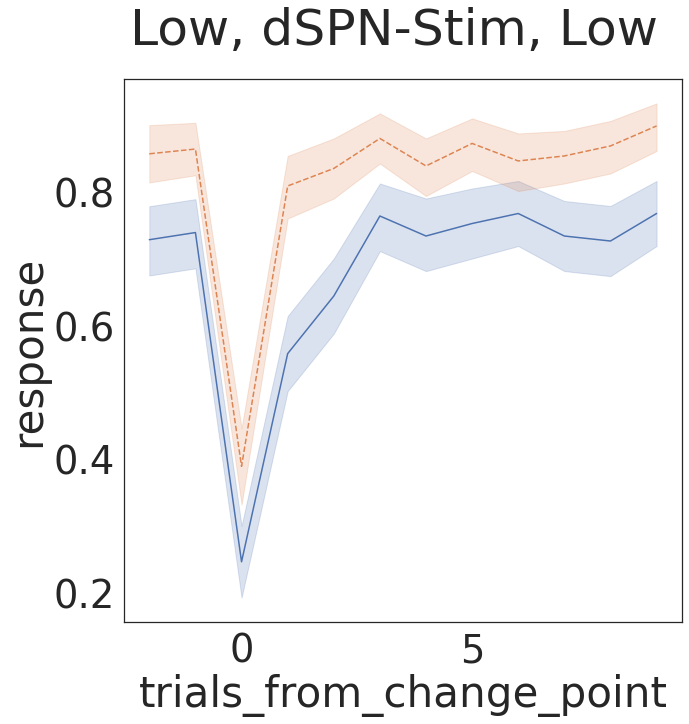

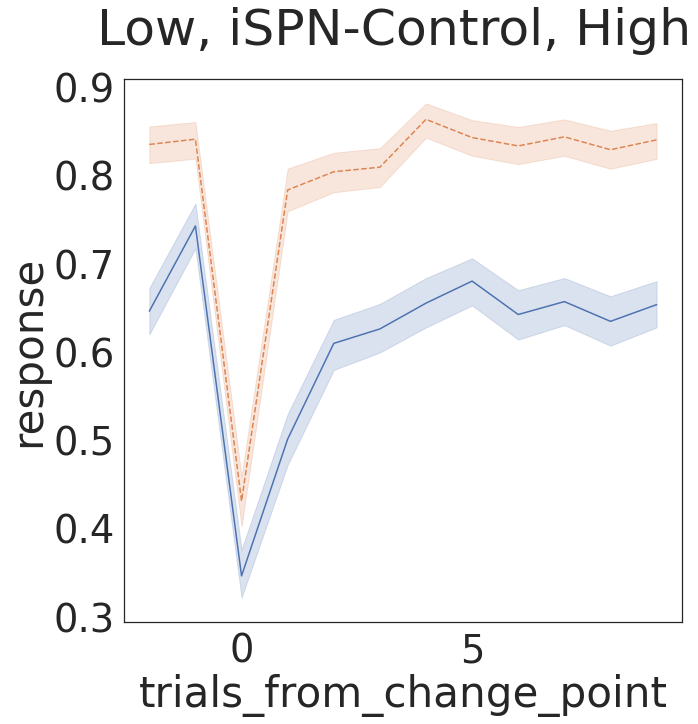

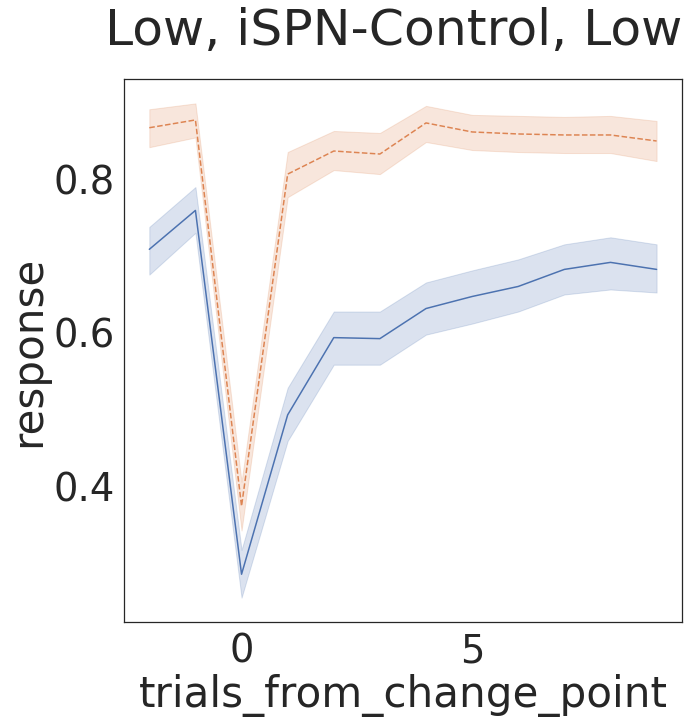

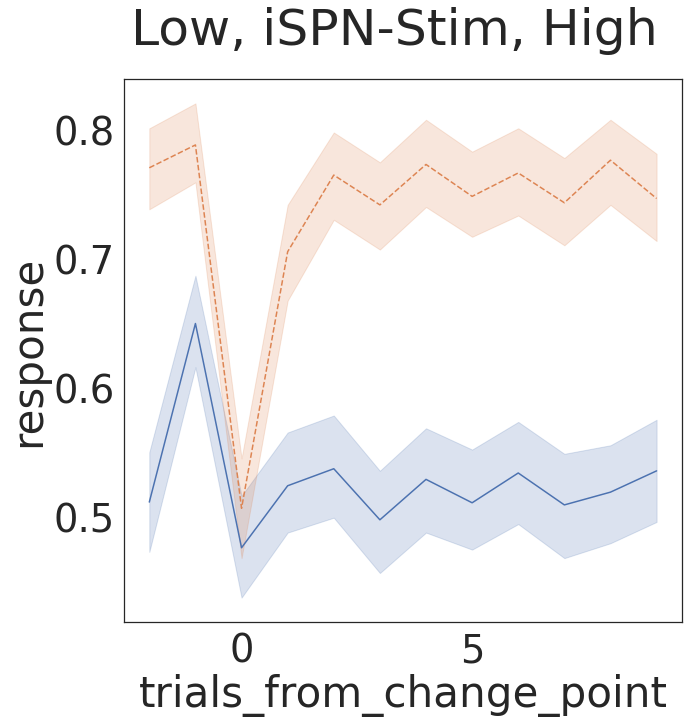

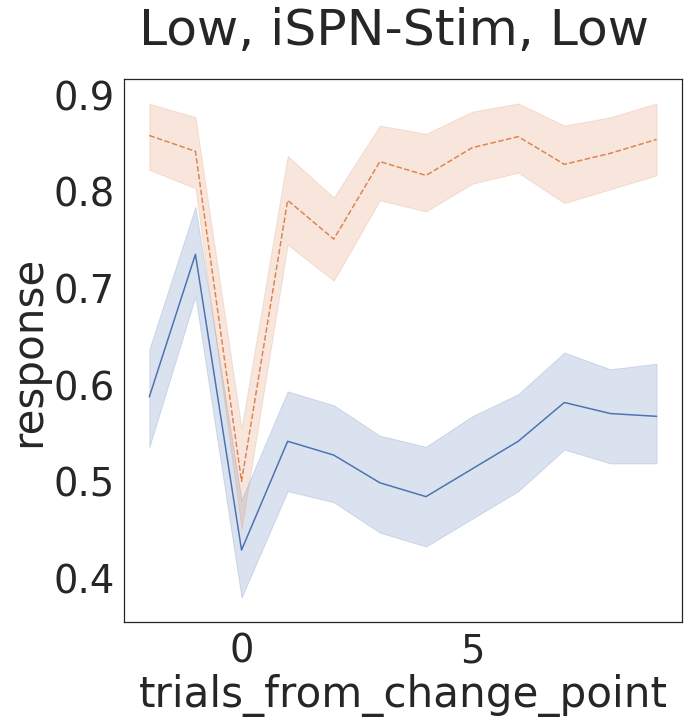

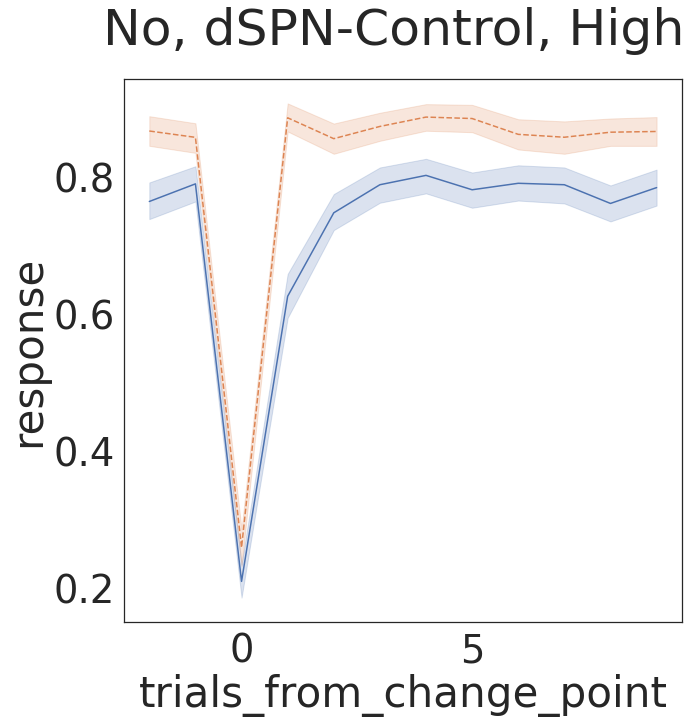

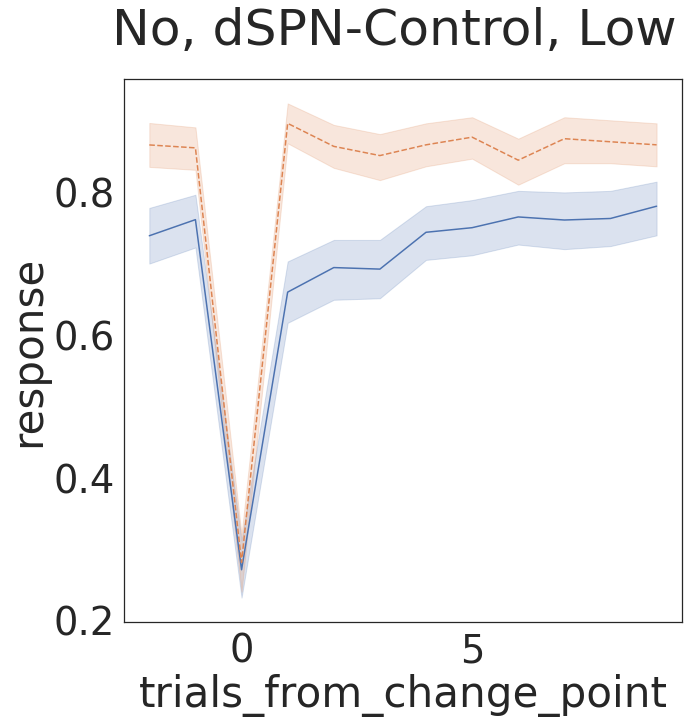

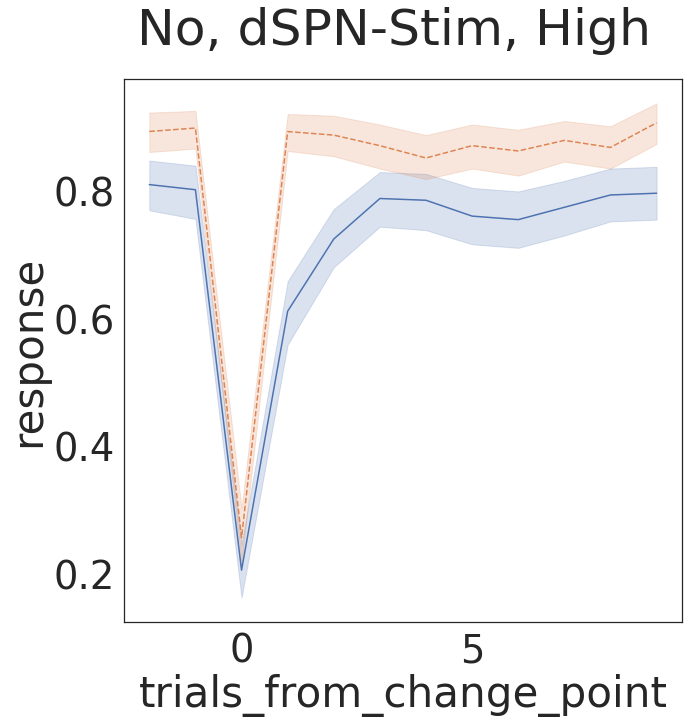

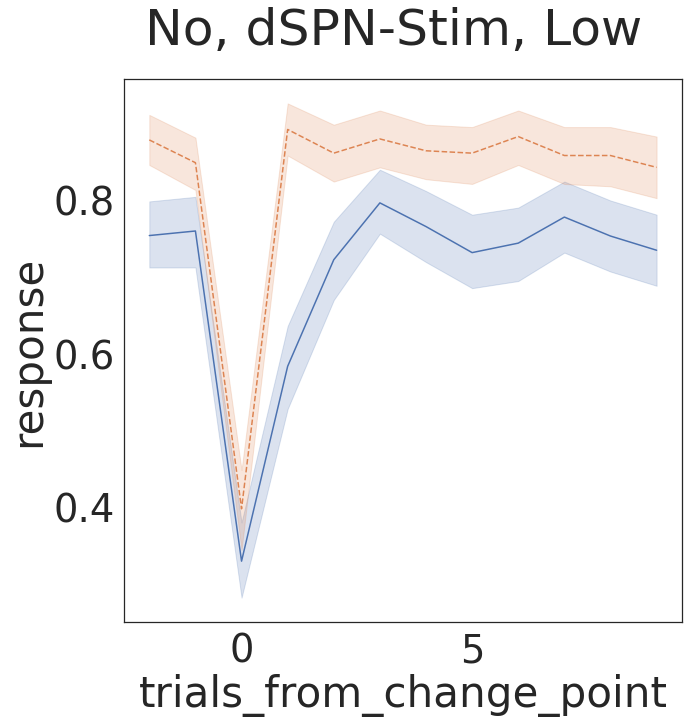

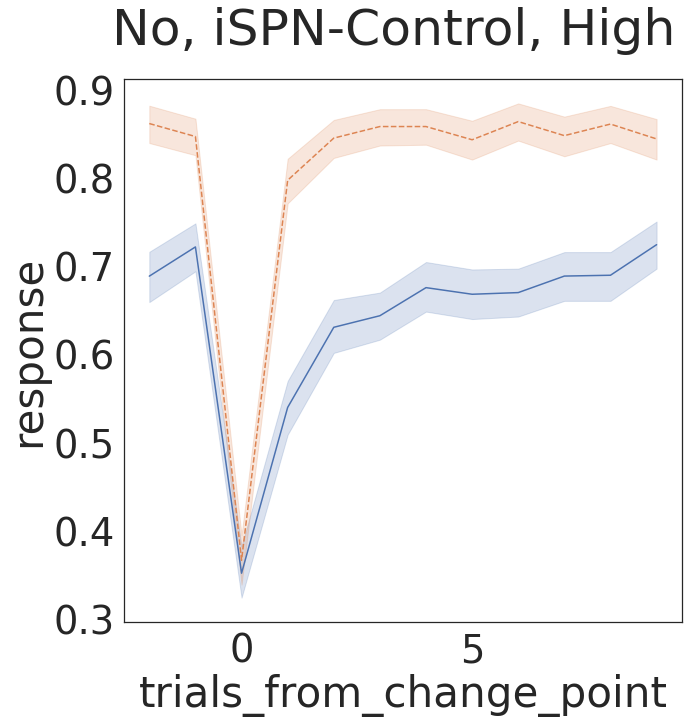

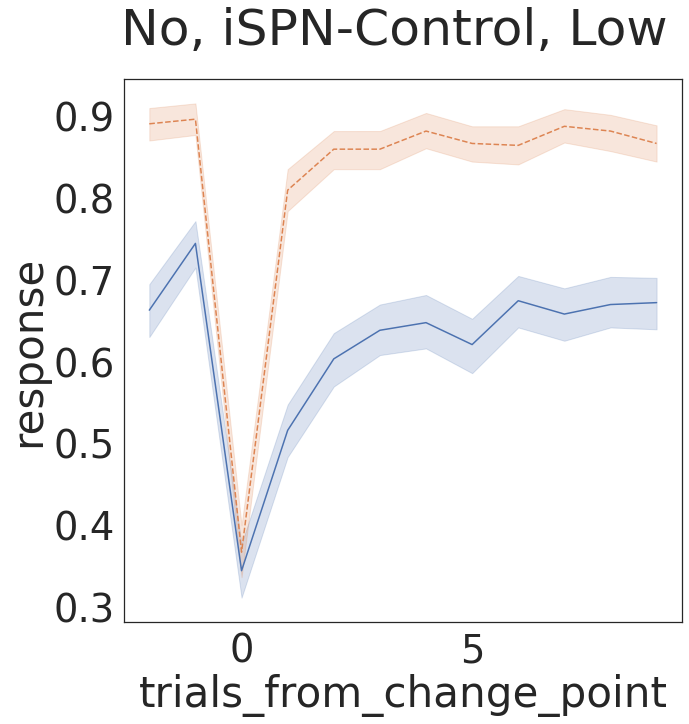

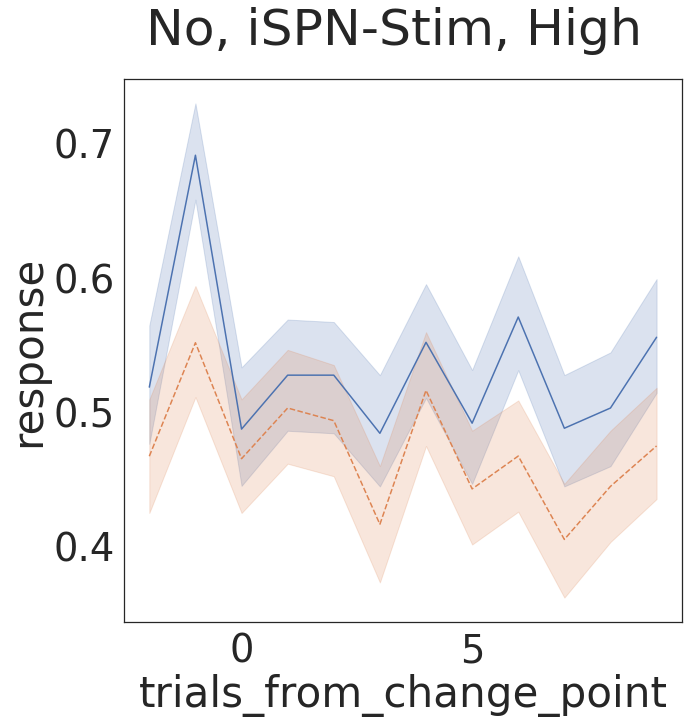

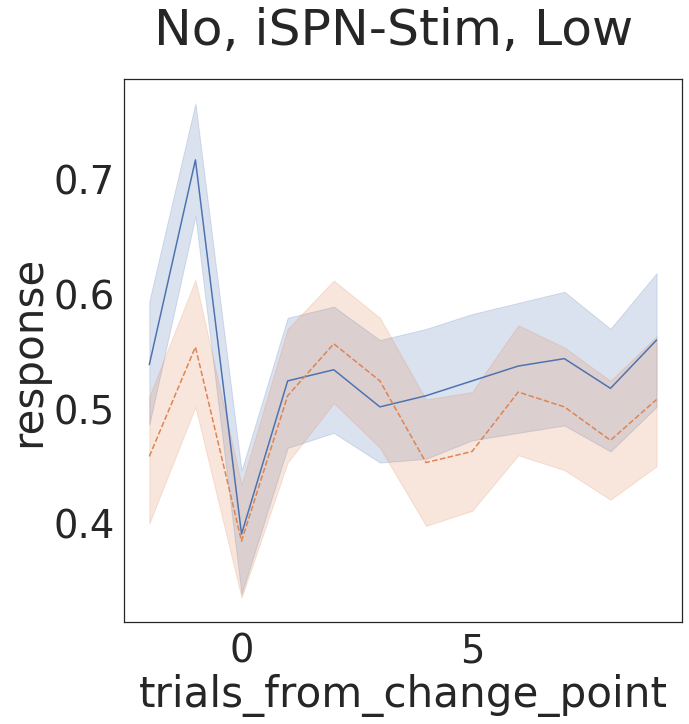

In [150]:
for grp in predicted_responses.groupby(["conflict","condition","volatility"]):
    fig,ax = pl.subplots(1,1,figsize=(10,10))
    fig.suptitle(grp[0][0]+", "+grp[0][1]+", "+grp[0][2])
    sns.lineplot(x="trials_from_change_point",y="response",data=grp[1],ax=ax)
    sns.lineplot(x="trials_from_change_point",y="predicted_response",data=grp[1],ax=ax,ls='dashed')
    fig.savefig(fig_target_dir+"actual_vs_predicted_"+grp[0][0]+"_"+grp[0][1]+"_"+grp[0][2]+".png")

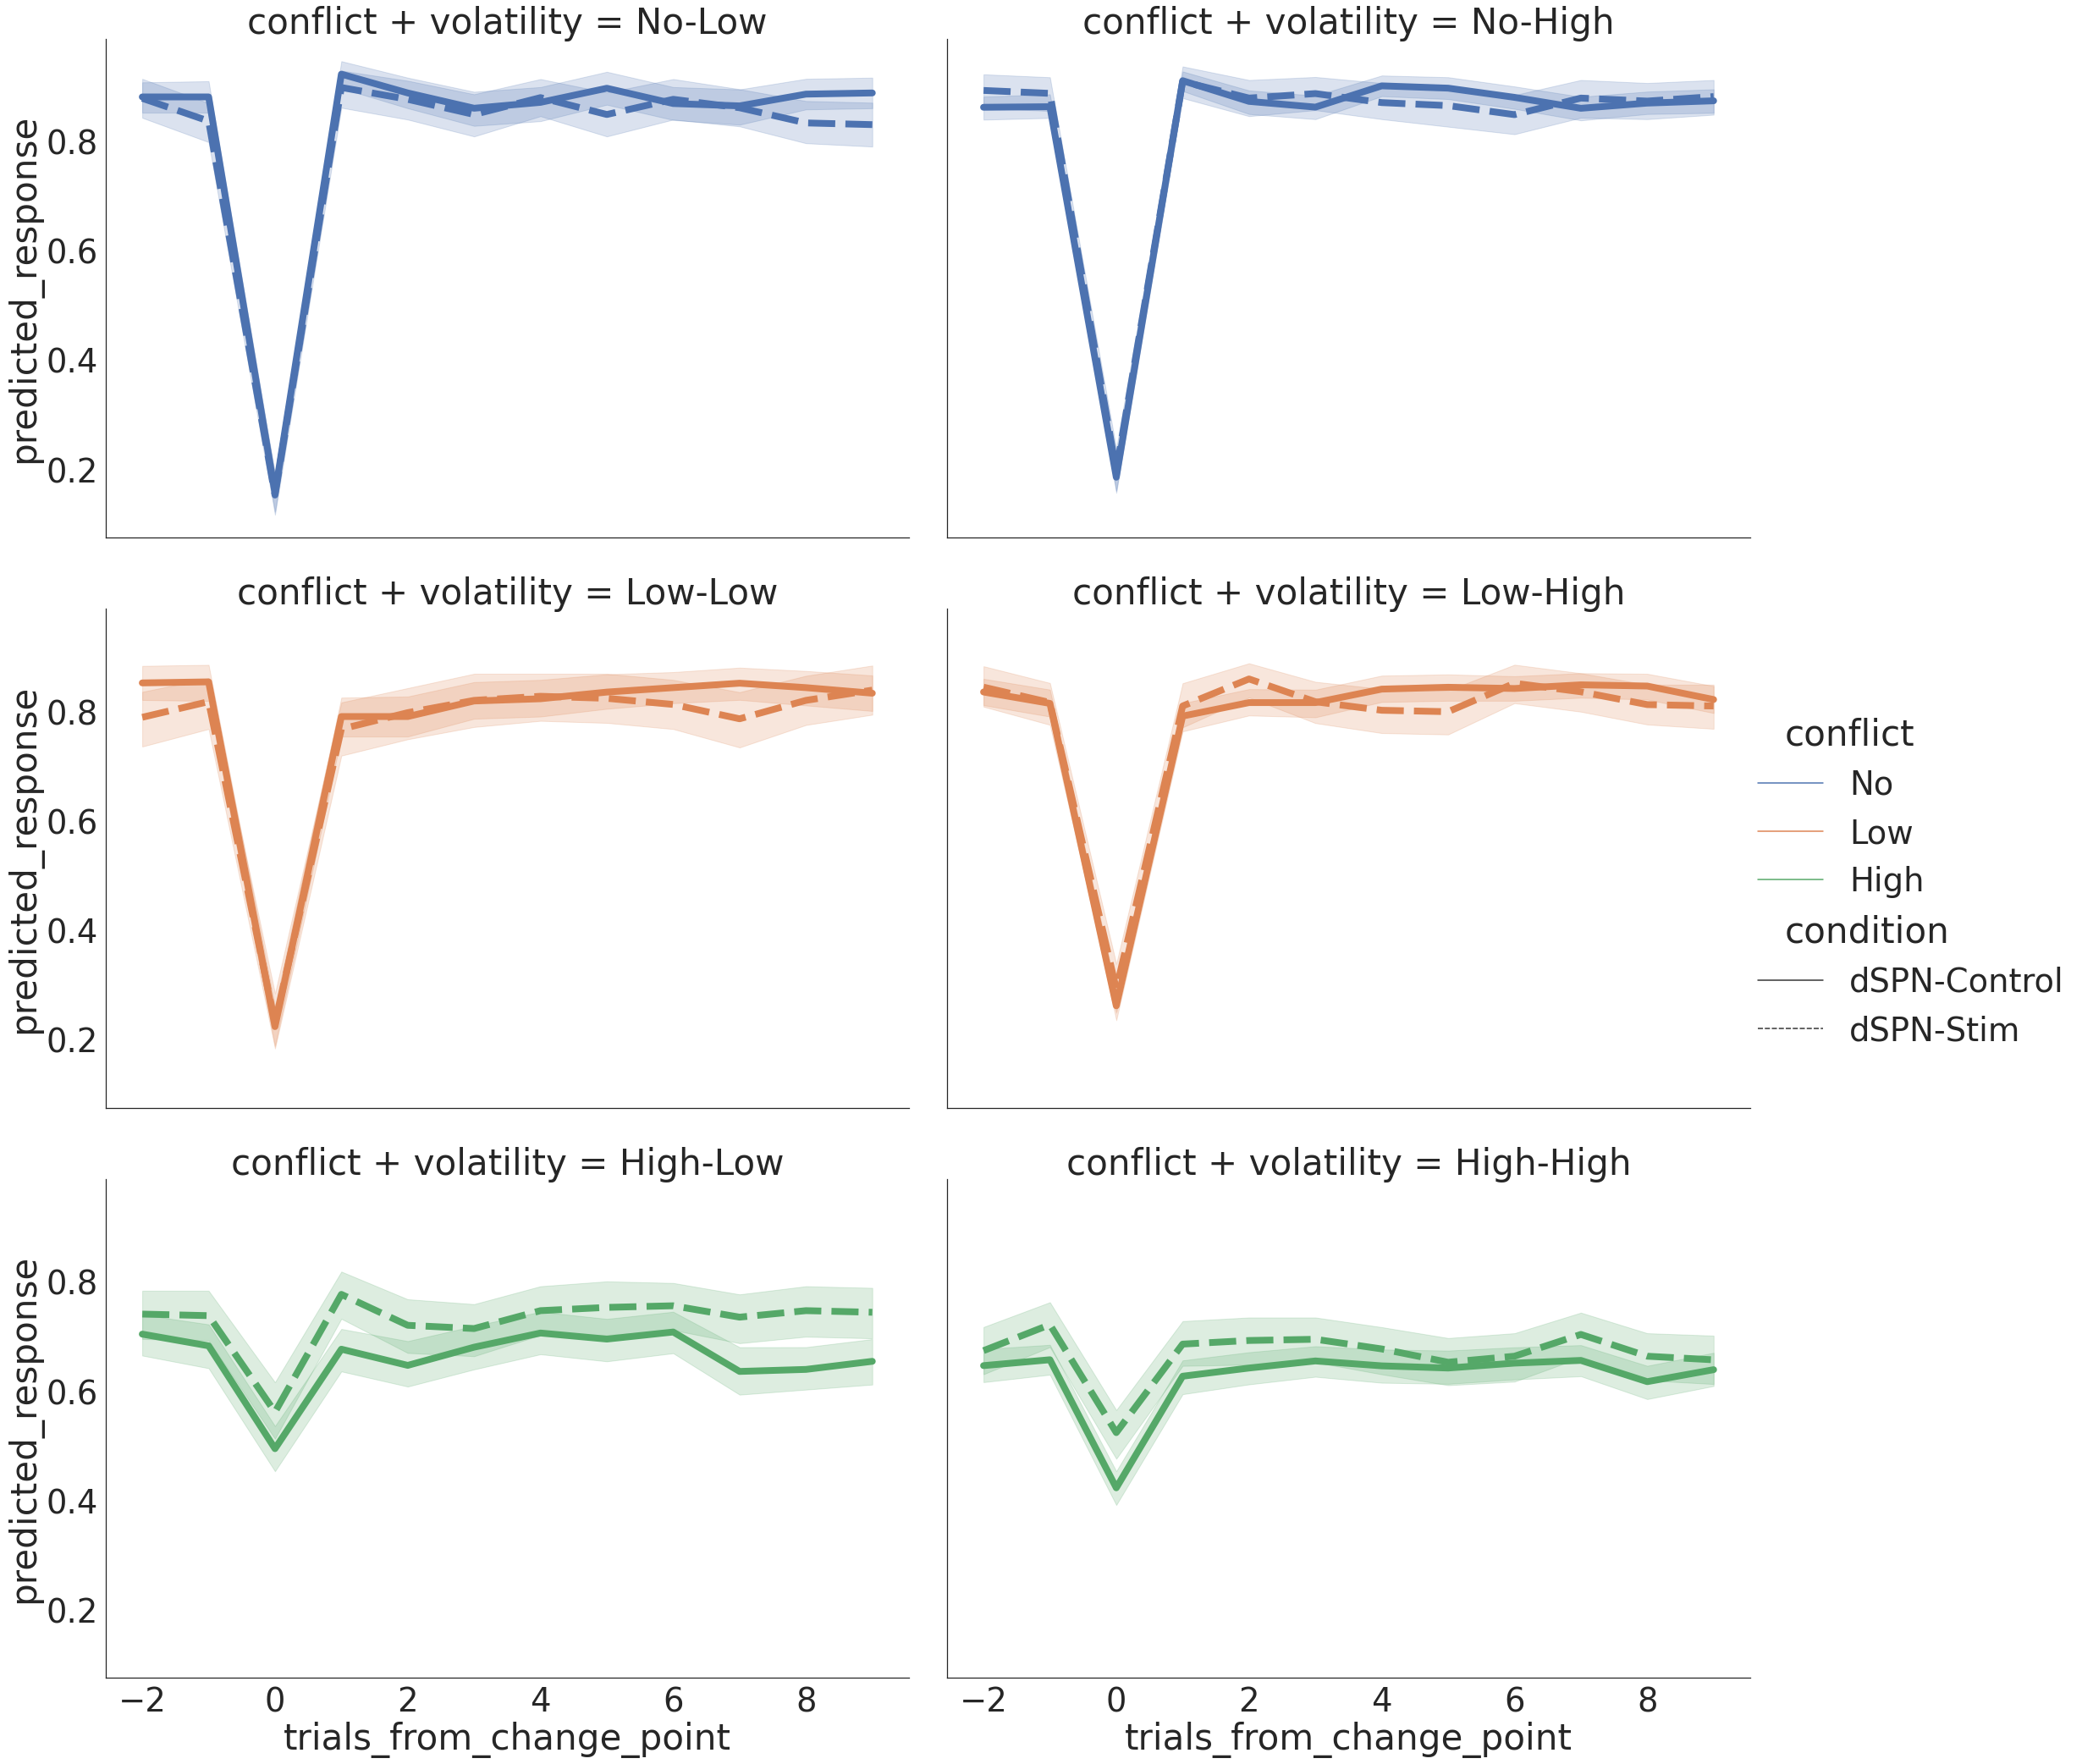

In [109]:
only_d1 = predicted_responses.loc[predicted_responses["nuclei"].str.contains("dSPN")]
sns.set(font_scale=3.5)
plt.rcParams["figure.facecolor"] = "w"
sns.set_style(style='white')
g1 = sns.relplot(x="trials_from_change_point",y="predicted_response",hue="conflict",col="conflict + volatility",style="condition",data=only_d1,kind='line',height=10,aspect=1.5,linewidth=8.0,hue_order=["No","Low","High"],col_order=["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"],palette='deep',col_wrap=2,facet_kws={'sharey':True})
g1.savefig(fig_target_dir+"predicted_response_from_b_cpp.png")

In [99]:
grp[1].iloc[test][["chosen_action","response","optimal"]]

,chosen_action,response,optimal
22059,left,1,left
22060,left,1,left
22061,left,1,left


In [102]:
y_predict

array([0, 1, 1])

In [103]:
temp["trials_from_change_point"]

178590   -2.0
178591   -1.0
178592    0.0
Name: trials_from_change_point, dtype: float64